<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L07/data_driven_ball_enclosing_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-Driven Enclosing Sphere Problem

In this notebook, we address a robust data-driven optimization problem where the goal is to determine a credible set that encloses most of the data scenarios. This is achieved by finding the smallest sphere (or ball) that contains the majority of data points, while also allowing for a few outliers using slack variables.

## Problem Formulation

### Without discarded samples

Consider a data set of scenarios:






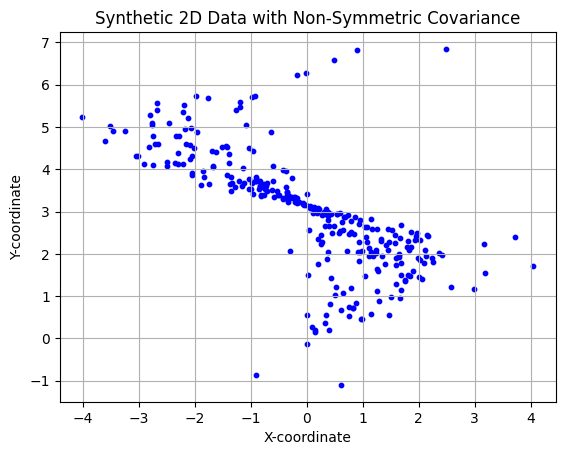

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic 2D data with more samples and non-symmetric distribution
np.random.seed(42)
num_samples = 300  # Increased number of samples
X = np.random.multivariate_normal([2, 3], [[1, 0.5], [0.5, 2]], num_samples) # Non-symmetric covariance
X[:,0] = np.sin(X[:,1])* X[:,0]
plt.scatter(X[:, 0], X[:, 1], color='blue', label="Data Points", s=10)
plt.grid()
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("Synthetic 2D Data with Non-Symmetric Covariance")
plt.show()




We define the enclosing set as a sphere:
$$
\mathcal{U} = \{ u \in \Omega : \|u - c\| \le r \}
$$
where:
- $c \in \mathbb{R}^n$ is the center.
- $r \ge 0$ is the radius.

The optimization problem is:
$$
\begin{aligned}
\min_{c, r} \quad & r \\
\text{subject to} \quad & \|u^{(i)} - c\|_2 \le r, \quad i = 1, \dots, N, \\
& r \ge 0.
\end{aligned}
$$

where $\|u^{(i)} - c\|_2$ is the Euclidean norm (distance) of each scenario from the ball center, e.g., $\sqrt{(u_x^{(i)} - c_x)^2 + (u_y^{(i)} - c_y)^2}$ for a 2-dimensional case.



Optimal center: [-0.07063222  3.25458338]
Optimal radius: 4.407304496566237


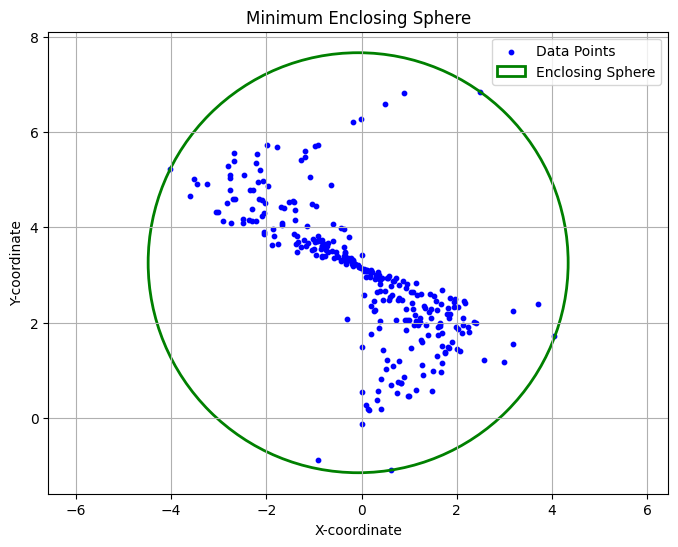

In [ ]:
# Decision variables: center (c) and radius (r)
c = cp.Variable(2)
r = cp.Variable(nonneg=True)

# Constraints: Enclosing sphere condition for each data point
constraints = [cp.norm(X[i] - c) <= r for i in range(X.shape[0])]

# Objective function: Minimize the radius of the sphere
objective = cp.Minimize(r)

# Define and solve the optimization problem
prob = cp.Problem(objective, constraints)
result = prob.solve()

print("Optimal center:", c.value)
print("Optimal radius:", r.value)

# Plot the data points and the enclosing sphere
plt.figure(figsize=(8, 6))  # Adjust figure size for better visualization
plt.scatter(X[:, 0], X[:, 1], color='blue', label="Data Points", s=10) # Reduced marker size for clarity
circle = plt.Circle(c.value, r.value, color='green', fill=False, label="Enclosing Sphere", linewidth=2) # Increased linewidth
plt.gca().add_patch(circle)
plt.axis('equal')
plt.title("Minimum Enclosing Sphere")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.legend()
plt.grid(True) # Added a grid for better readability
plt.show()


### With discarded samples (Outliers)

To account for outliers, slack variables \(\xi_i \ge 0\) are introduced:
$$
\|u^{(i)} - c\| \le r + \xi_i.
$$
The robust formulation becomes:
$$
\begin{aligned}
\min_{c, r, \xi} \quad & r + \lambda \sum_{i=1}^{N} \xi_i \\
\text{subject to} \quad & \|u^{(i)} - c\| \le r + \xi_i, \quad i = 1, \dots, N, \\
& \xi_i \ge 0, \quad i = 1, \dots, N, \\
& r \ge 0.
\end{aligned}
$$
where $\lambda > 0$ is a penalty parameter.

4
Optimal center (with outliers): [-0.07063221  3.25458338]
Optimal radius (with outliers): 4.407304491318084
Optimal center (with outliers): [-0.12837584  3.2213229 ]
Optimal radius (with outliers): 3.73621919892853
Optimal center (with outliers): [-0.11642887  3.39184749]
Optimal radius (with outliers): 3.246481480243095
Optimal center (with outliers): [-0.17918894  2.92322027]
Optimal radius (with outliers): 2.315055150587797


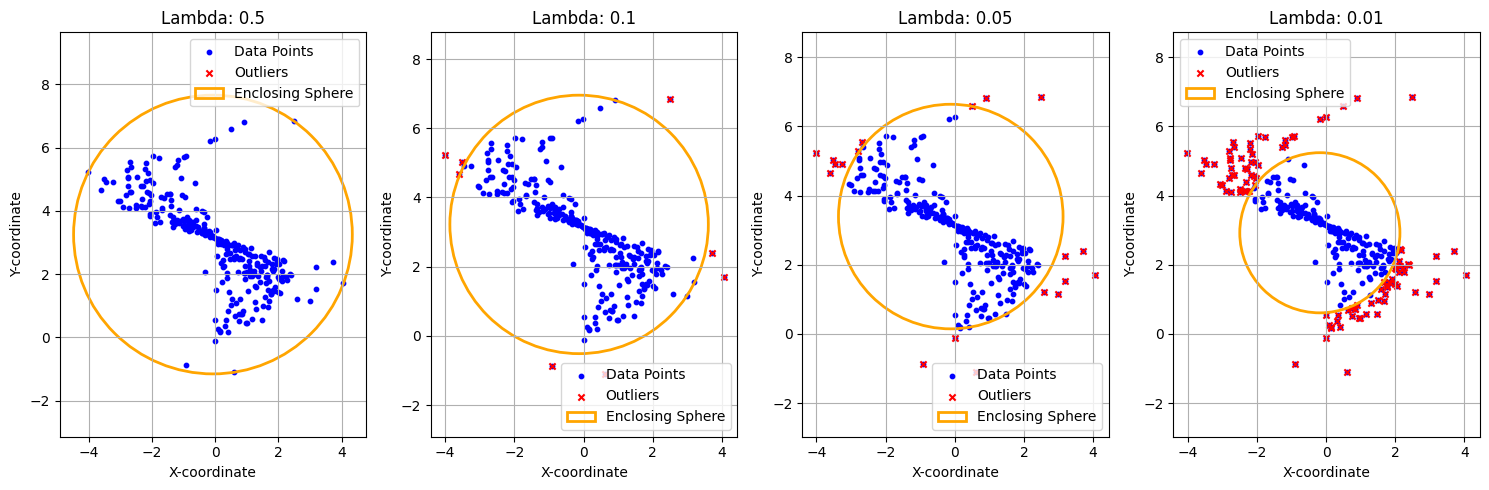

In [ ]:
# Generate synthetic 2D data with more samples and non-symmetric distribution
np.random.seed(42)
num_samples = 300  # Increased number of samples
X = np.random.multivariate_normal([2, 3], [[1, 0.5], [0.5, 2]], num_samples) # Non-symmetric covariance
X[:,0] = np.sin(X[:,1])* X[:,0]


lambda_parameter_values = [0.5, 0.1, 0.05, 0.01]
print(len(lambda_parameter_values))

fig, axs = plt.subplots(1, len(lambda_parameter_values), figsize=(15, 5))

for id, lambda_param in enumerate(lambda_parameter_values):  # Penalty parameter (lambda) - adjust as needed
  # Decision variables
  c = cp.Variable(2)
  r = cp.Variable(nonneg=True)
  xi = cp.Variable(num_samples, nonneg=True) # Use xi instead of si
  # Constraints
  constraints = [cp.norm(X[i] - c) <= r + xi[i] for i in range(num_samples)]
  # Objective function
  objective = cp.Minimize(r + lambda_param * cp.sum(xi)) # Correct objective function
  # Define and solve the problem
  prob = cp.Problem(objective, constraints)
  result = prob.solve()
  print("Optimal center (with outliers):", c.value)
  print("Optimal radius (with outliers):", r.value)
  # Identify outliers
  outliers = np.where(xi.value > 1e-6)[0] # Use a threshold to identify outliers
  # Plot
  axs[id].scatter(X[:, 0], X[:, 1], color='blue', label="Data Points", s=10)
  axs[id].scatter(X[outliers, 0], X[outliers, 1], color='red', label="Outliers", s=20, marker='x')
  circle = plt.Circle(c.value, r.value, color='orange', fill=False, label="Enclosing Sphere", linewidth=2)
  axs[id].add_patch(circle)
  axs[id].axis('equal')
  axs[id].set_title(f"Lambda: {lambda_param}")
  axs[id].set_xlabel("X-coordinate")
  axs[id].set_ylabel("Y-coordinate")
  axs[id].legend()
  axs[id].grid(True)

plt.tight_layout()
plt.show()
